C:\Users\amit\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


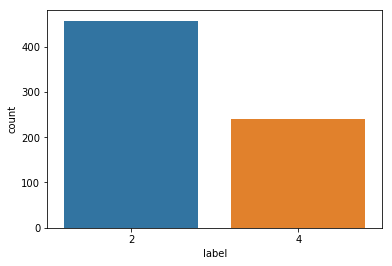

Sample code number            -0.080378
Clump_Thickness                0.716509
Uniformity_of_Cell_Size        0.817772
Uniformity_of_Cell_Shape       0.818794
Marginal_Adhesion              0.696605
Single_Epithelial_Cell_Size    0.682618
Bare_Nuclei                    0.706209
Bland_Chromatin                0.756732
Normal_Nucleoli                0.712067
Mitoses                        0.423008
label                          1.000000
Name: label, dtype: float64

In [31]:
import pandas as pd
import numpy as np
data=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data')
data.columns=['Sample code number','Clump_Thickness','Uniformity_of_Cell_Size','Uniformity_of_Cell_Shape','Marginal_Adhesion','Single_Epithelial_Cell_Size','Bare_Nuclei','Bland_Chromatin','Normal_Nucleoli','Mitoses','label']
data=data.replace('?',15)
data['Bare_Nuclei']=data['Bare_Nuclei'].astype(dtype='i')
data.corr()['label']
import seaborn as sb
import matplotlib.pyplot as plt
sb.countplot('label',data=data)
plt.savefig('f:/breast_cancer_count.png')
plt.show()
data.corr()['label']

In [4]:
data.drop('Sample code number',axis=1,inplace=True)# due to no correlation we need to drop thid column

In [5]:
import random as r

In [6]:
def tr_te_split(dtf, t_size):
    t_size = int(t_size * dtf.shape[0]) # calculating the testsize according to the length of data
    indexes = dtf.index.tolist() # we will take the index of the data-frame to randomize
    t_index = r.sample(population=indexes, k=t_size) #using the random randomizing the indexes
    test_df = dtf.loc[t_index]   #seprating the random test_data based on the random indexes obtained from t_index
    train_df = dtf.drop(t_index)  # in train data we need to remove the t_index as it is in the test data
    return train_df, test_df

In [7]:
train, test = tr_te_split(data, t_size=0.2)
data.shape,train.shape,test.shape,test.index

((698, 10),
 (559, 10),
 (139, 10),
 Int64Index([292, 689,  54, 587, 496,  20, 417, 299,   3, 592,
             ...
             328, 608, 157, 688, 221, 218, 300, 551, 404, 316],
            dtype='int64', length=139))

In [8]:
class Tree:
    def type_of_cols(sf,data):
        # if the availabe no of unique values of a column is greater than 5 then it can be classified as continues
        #else as categorial
        col_type_and_name=[]
        col_type=[]
        no_of_unique=5
        for col in data.columns[:-1]:
            no_of_col_unique= data[col].nunique()
            if data[col].dtypes==object or no_of_col_unique<no_of_unique:
                col_type_and_name.append((col,"categorical"))
                col_type.append("categorical")
            else:
                col_type_and_name.append((col,"continuous"))
                col_type.append("continuous")
        return col_type
    def get_splits(sf,data):
        splits = {} # dict to store the possible splits of our data based on either categorial or continues data
        feature_type=sf.type_of_cols(data) # get the type of data of each column of feature set
        for column_index in range(data.shape[1]-1):          # excluding the last column which is the label
            values = data.iloc[:, column_index] # accessing the all the column value based on index nor the column name
            unique_values = np.unique(values) #fetch the unique values of the respective column
            type_of_feature = feature_type[column_index] # get data type of column i.e categorial or continues
            if type_of_feature == "continuous":
                splits[column_index] = []
                for index in range(len(unique_values)):
                    if index != 0:
                        current_value = unique_values[index]
                        previous_value = unique_values[index - 1]
                        split = (current_value + previous_value) / 2
                        splits[column_index].append(split)
            # feature is categorical(there need to be at least 2 unique values, otherwise in the 
            #split_data function data_below would contain all data points and data_above would be empty)
            elif len(unique_values) > 1:
                splits[column_index] = unique_values
        return splits
    def split_data(sf,data, column, value):
        #based on to column's data type we will destribute the data into two portion's 
        feature_type=sf.type_of_cols(data)
        split_values = data.iloc[:,column]
        type_of_feature = feature_type[column]
        if type_of_feature == "continuous": # in case of continues data we will use greater or lesser than operator
            left = data[split_values <= value]
            right = data[split_values >  value]
        else:# in case of categorial data will use logical equal or not equal operator
            left = data[split_values == value]
            right = data[split_values != value]
        return left,right

    def entropy(sf,data):#we are calculating the entropy of class 
        prob=list(dict(data.iloc[:, -1].value_counts(normalize=True)).values())
        entropy = sum(prob* -np.log2(prob))    
        return entropy

    def entropy_data(sf,left,right):    
        n = len(left) + len(right)
        p_left = len(left) / n
        p_right = len(right) / n
        entropy_ =  (p_left * sf.entropy(left)+ p_right *sf.entropy(right))
        return entropy_
    
    def best_split(sf,data,splits):
        entropy = 9999 #we assume a dummy entropy to compare with obtained entropy for the first time 
        for col in splits: # iterating over the splits obtained by the get_split method for each columns
            for val in splits[col]: # iterating over the splits of a indivisual columns
                left, right = sf.split_data(data, column=col, value=val)# spliting the data according to obtained split(val) of a column
                current_entropy = sf.entropy_data(left,right) #calculating the entropy of a column
                if current_entropy <= entropy: # if obtained entropy is lesser than assumed entropy 
                    entropy = current_entropy #then assume the obtained entropy as best entropy
                    best_column = col # the current column can be termend as best column and the split too
                    best_split = val
        return best_column, best_split
    
    def tree_builder(sf,df, counter=0, min_samples=2, max_depth=5):
        from collections import Counter
        # data preparations
        column=df.columns #store the column name
        feature_type=sf.type_of_cols(df) # store the column value type i.e categorial/continues 
        data = df
        # base cases
        if (df.iloc[:,-1].nunique()==1) or (len(data) < min_samples) or (counter == max_depth):
            classes= Counter(data.iloc[:,-1]).most_common(1)[0][0]
            return classes
        # recursive part
        else:    
            counter += 1
            splits = sf.get_splits(data)#calculating the splits of each columns
            split_column, split_value = sf.best_split(data,splits) #getting the best column and split value
            left, right = sf.split_data(data, split_column, split_value) # based on the above split and column divide the data 
            # determine question
            feature_name = column[split_column] #pick the column name
            type_of_feature = feature_type[split_column]
            if type_of_feature == "continuous":
                question = "{} <= {}".format(feature_name, split_value) # assign the column name ,type of operator to be used and the split value            
            # feature is categorical
            else:
                question = "{} = {}".format(feature_name, split_value)
            # instantiate sub-tree
            mytree = {question: []}
            # find answers (recursion)
            ans_yes = sf.tree_builder(left, counter, min_samples, max_depth) # left leave is for yes where tree traversal stops
            ans_no = sf.tree_builder(right, counter, min_samples, max_depth) # right leave needs few more nodes
            # If the answers are the same, then there is no point in asking the question.
            # This could happen when the data is classified even though it is not pure
            # yet (min_samples or max_depth base case).
            if ans_yes == ans_no:
                mytree = ans_yes
            else:
                mytree[question].append(ans_yes)
                mytree[question].append(ans_no)
        
            return mytree

In [9]:
alg=Tree()
tree=alg.tree_builder(train)
tree

{'Uniformity_of_Cell_Size <= 2.5': [{'Clump_Thickness <= 6.5': [{'Normal_Nucleoli <= 4.5': [2,
      {'Bland_Chromatin = 7': [4, 2]}]},
    {'Bare_Nuclei <= 2.0': [2, 4]}]},
  {'Uniformity_of_Cell_Size <= 4.5': [{'Bare_Nuclei <= 6.0': [{'Normal_Nucleoli <= 1.5': [2,
        {'Clump_Thickness <= 4.5': [2, 4]}]},
      {'Bare_Nuclei <= 12.5': [4, 2]}]},
    4]}]}

In [10]:
class DecisionTree(Tree):
    def fit(sf,train):
        sf.tree=sf.tree_builder(train)
        return sf.tree
    def predict(sf,dx,tree):
        root_node = list(tree.keys())[0] # fetch the root node's value i.e our dict keys which consits of column name,operator and split value 
        column,operator,split=root_node.split(" ") # we have used the space as a seprator b/w the three data
        if operator == "<=": # if the operator is lesser than or equal it means th column type is continues
            
            if dx[column] <= float(split):
                result = tree[root_node][0]
            else:
                result = tree[root_node][1]
        # if column  is categorical then we can use logical equal operator
        else:
            if str(dx[column]) == split:
                result = tree[root_node][0]
            else:
                result = tree[root_node][1]
        if type(result)!=dict: # if the result is dict then we have more nodes to be traversed
            return result
        # else recursively travers the entire tree for accurate results
        else:
            return sf.predict(dx,result)
    def score(sf,x,y):
        c=0 # we will pass a indivisual x into predict and compare the given y with the predicted y if both are equal then c will be incremented by 1 
        for i in range(len(x)):
            if sf.predict(x.iloc[i],sf.tree)==y.iloc[i]:
                c+=1
        return c/len(x) # finally resultant is correct prediction by the total len of x

In [11]:
algo=DecisionTree()
algo.fit(train)

{'Uniformity_of_Cell_Size <= 2.5': [{'Clump_Thickness <= 6.5': [{'Normal_Nucleoli <= 4.5': [2,
      {'Bland_Chromatin = 7': [4, 2]}]},
    {'Bare_Nuclei <= 2.0': [2, 4]}]},
  {'Uniformity_of_Cell_Size <= 4.5': [{'Bare_Nuclei <= 6.0': [{'Normal_Nucleoli <= 1.5': [2,
        {'Clump_Thickness <= 4.5': [2, 4]}]},
      {'Bare_Nuclei <= 12.5': [4, 2]}]},
    4]}]}

In [12]:
test_x=test.drop('label',axis=1)
test_y=test['label']
algo.score(test_x,test_y)

0.920863309352518

In [13]:
class RTree:
    def type_of_cols(sf,data):
        # if the availabe no of unique values of a column is greater than 5 then it can be classified as continues
        #else as categorial
        col_type_and_name=[]
        col_type=[]
        no_of_unique=5
        for col in data.columns[:-1]:
            no_of_col_unique= data[col].nunique()
            if data[col].dtypes==object or no_of_col_unique<no_of_unique:
                col_type_and_name.append((col,"categorical"))
                col_type.append("categorical")
            else:
                col_type_and_name.append((col,"continuous"))
                col_type.append("continuous")
        return col_type
    def get_splits(sf,data,rnd):
        splits = {}
        col = data.shape[1]
        col= list(range(col - 1))    # leaving the label
    
        if rnd and rnd <= len(col):
            col = r.sample(population=col, k=rnd)
        for c in col:  
            val = data.iloc[:, c]
            u_val = np.unique(val)
        
            splits[c] = u_val
        return splits
    def split_data(sf,data, column, value):
        #based on to column's data type we will destribute the data into two portion's 
        feature_type=sf.type_of_cols(data)
        split_values = data.iloc[:,column]
        type_of_feature = feature_type[column]
        if type_of_feature == "continuous": # in case of continues data we will use greater or lesser than operator
            left = data[split_values <= value]
            right = data[split_values >  value]
        else:# in case of categorial data will use logical equal or not equal operator
            left = data[split_values == value]
            right = data[split_values != value]
        return left,right

    def entropy(sf,data):#we are calculating the entropy of class 
        prob=list(dict(data.iloc[:, -1].value_counts(normalize=True)).values())
        entropy = sum(prob* -np.log2(prob))    
        return entropy

    def entropy_data(sf,left,right):    
        n = len(left) + len(right)
        p_left = len(left) / n
        p_right = len(right) / n
        entropy_ =  (p_left * sf.entropy(left)+ p_right *sf.entropy(right))
        return entropy_
    
    def best_split(sf,data,splits):
        entropy = 9999 #we assume a dummy entropy to compare with obtained entropy for the first time 
        for col in splits: # iterating over the splits obtained by the get_split method for each columns
            for val in splits[col]: # iterating over the splits of a indivisual columns
                left, right = sf.split_data(data, column=col, value=val)# spliting the data according to obtained split(val) of a column
                current_entropy = sf.entropy_data(left,right) #calculating the entropy of a column
                if current_entropy <= entropy: # if obtained entropy is lesser than assumed entropy 
                    entropy = current_entropy #then assume the obtained entropy as best entropy
                    best_column = col # the current column can be termend as best column and the split too
                    best_split = val
        return best_column, best_split
    
    def tree_builder(sf,df, counter=0, min_samples=2, depth=5,rnd=2):
        from collections import Counter
        # data preparations
        column=df.columns #store the column name
        feature_type=sf.type_of_cols(df) # store the column value type i.e categorial/continues 
        data = df
        # base cases
        if (df.iloc[:,-1].nunique()==1) or (len(data) < min_samples) or (counter == depth):
            try:
                classes= Counter(data.iloc[:,-1]).most_common(1)[0][0]
                return classes
            except:
                return
            
        # recursive part
        else:    
            counter += 1
            splits = sf.get_splits(data,rnd)#calculating the splits of each columns
            split_column, split_value = sf.best_split(data,splits) #getting the best column and split value
            left, right = sf.split_data(data, split_column, split_value) # based on the above split and column divide the data 
            # determine question
            feature_name = column[split_column] #pick the column name
            type_of_feature = feature_type[split_column]
            if type_of_feature == "continuous":
                question = "{} <= {}".format(feature_name, split_value) # assign the column name ,type of operator to be used and the split value            
            # feature is categorical
            else:
                question = "{} = {}".format(feature_name, split_value)
            # instantiate sub-tree
            mytree = {question: []}
            # find answers (recursion)
            ans_yes = sf.tree_builder(left, counter, min_samples, depth,rnd) # left leave is for yes where tree traversal stops
            ans_no = sf.tree_builder(right, counter, min_samples, depth,rnd) # right leave needs few more nodes
            # If the answers are the same, then there is no point in asking the question.
            # This could happen when the data is classified even though it is not pure
            # yet (min_samples or max_depth base case).
            if ans_yes == ans_no:
                mytree = ans_yes
            else:
                mytree[question].append(ans_yes)
                mytree[question].append(ans_no)
        
            return mytree

In [14]:
class RForestClas(RTree,DecisionTree):
    def bstrap(sf,tr, n_bstrap):
        bstrap_indexes=np.random.randint(low=0, high=len(tr), size=n_bstrap)
        data_bstrapped = tr.iloc[bstrap_indexes]
        return data_bstrapped
    def fit(sf,tr, number_of_trees, n_bstrap,depth):
        sf.myfor = []
        for i in range(number_of_trees):
            data_bstrapped = sf.bstrap(tr, n_bstrap)
            single_tree = sf.tree_builder(data_bstrapped)
            sf.myfor.append(single_tree)
        return sf.myfor

    def r_predict(sf,ts):
        data_predict = {}
        for f in range(len(sf.myfor)):
            prds = sf.predict(ts, sf.myfor[f])
            data_predict[f] = prds
        predicted= pd.DataFrame()
        predicted[0]=data_predict.values()
        r_f_predictions = predicted.mode(axis=0)[0]
        return r_f_predictions
    def score(sf,x,y):
        c=0 # we will pass a indivisual x into predict and compare the given y with the predicted y if both are equal then c will be incremented by 1 
        for i in range(len(x)):
            res=dict(sf.r_predict(x.iloc[i]))
            if res[0]==y.iloc[i]:
                c+=1
        return c/len(x) # finally resultant is correct prediction by the total len of x

In [16]:
algo1=RForestClas()
algo1.fit(train, 4, 800, depth=4)
algo1.score(test_x,test_y)
algo1.myfor

[{'Normal_Nucleoli <= 2': [{'Clump_Thickness <= 6': [{'Bland_Chromatin <= 4': [{'Bare_Nuclei <= 8': [2,
         {'Uniformity_of_Cell_Size = 1': [2, 4]}]},
       {'Clump_Thickness <= 2': [2, {'Marginal_Adhesion <= 1': [2, 4]}]}]},
     {'Marginal_Adhesion <= 3': [{'Bare_Nuclei <= 2': [{'Bland_Chromatin = 5': [4,
           2]},
         4]},
       4]}]},
   {'Bare_Nuclei <= 3': [{'Marginal_Adhesion <= 6': [{'Single_Epithelial_Cell_Size <= 2': [2,
         {'Bare_Nuclei = 2': [4, 2]}]},
       4]},
     {'Marginal_Adhesion <= 6': [{'Bare_Nuclei <= 10': [4, 2]}, 4]}]}]},
 {'Uniformity_of_Cell_Shape <= 2': [{'Clump_Thickness <= 5': [{'Marginal_Adhesion <= 6': [2,
       4]},
     {'Bland_Chromatin <= 3': [{'Mitoses = 2': [4, 2]},
       {'Single_Epithelial_Cell_Size <= 1': [2, 4]}]}]},
   {'Bland_Chromatin <= 4': [{'Uniformity_of_Cell_Size <= 2': [{'Normal_Nucleoli = 3': [4,
         2]},
       {'Uniformity_of_Cell_Shape <= 7': [{'Bare_Nuclei <= 1': [2, 4]}, 4]}]},
     {'Bare_Nuclei <

In [18]:
print(*algo1.myfor,sep='\nTrees\n\n\n')

{'Normal_Nucleoli <= 2': [{'Clump_Thickness <= 6': [{'Bland_Chromatin <= 4': [{'Bare_Nuclei <= 8': [2, {'Uniformity_of_Cell_Size = 1': [2, 4]}]}, {'Clump_Thickness <= 2': [2, {'Marginal_Adhesion <= 1': [2, 4]}]}]}, {'Marginal_Adhesion <= 3': [{'Bare_Nuclei <= 2': [{'Bland_Chromatin = 5': [4, 2]}, 4]}, 4]}]}, {'Bare_Nuclei <= 3': [{'Marginal_Adhesion <= 6': [{'Single_Epithelial_Cell_Size <= 2': [2, {'Bare_Nuclei = 2': [4, 2]}]}, 4]}, {'Marginal_Adhesion <= 6': [{'Bare_Nuclei <= 10': [4, 2]}, 4]}]}]}
Trees


{'Uniformity_of_Cell_Shape <= 2': [{'Clump_Thickness <= 5': [{'Marginal_Adhesion <= 6': [2, 4]}, {'Bland_Chromatin <= 3': [{'Mitoses = 2': [4, 2]}, {'Single_Epithelial_Cell_Size <= 1': [2, 4]}]}]}, {'Bland_Chromatin <= 4': [{'Uniformity_of_Cell_Size <= 2': [{'Normal_Nucleoli = 3': [4, 2]}, {'Uniformity_of_Cell_Shape <= 7': [{'Bare_Nuclei <= 1': [2, 4]}, 4]}]}, {'Bare_Nuclei <= 1': [{'Uniformity_of_Cell_Shape = 3': [2, 4]}, 4]}]}]}
Trees


{'Uniformity_of_Cell_Shape <= 3': [{'Bare_Nuc

In [11]:
import numpy as np
import math
import matplotlib.pyplot as pt
import pandas as pd

def shffle_dta(ft, tar, sed=None):
    """ Random shuffle of the samples in X and y """
    if sed:
        np.random.seed(sed)
    id_ft = np.arange(ft.shape[0])
    np.random.shuffle(id_ft)
    return ft[id_ft], tar[id_ft]

def trval_tsval_splt(ft, tar, tst_sze=0.5, shffle=True, sed=None):
    """ Split the data into train and test sets """
    if shffle:
        ft, tar = shffle_dta(ft, tar, sed)
    # Split the training data from test data in the ratio specified in
    # test_size
    splt_i = len(tar) - int(len(tar) // (1 / tst_sze))
    ft_trval, ft_tsval = ft[:splt_i], ft[splt_i:]
    tar_trval, tar_tsval = tar[:splt_i], tar[splt_i:]

    return ft_trval, ft_tsval, tar_trval, tar_tsval

def ac_scr(y_tr, y_pd):
    acc = np.sum(y_tr == y_pd, axis=0) / len(y_tr)
    return acc

class Dec_Stmp():
    def __init__(sf):
        sf.polrty = 1
        sf.f_ind = None
        sf.thshld = None
        sf.alpha = None

class AdaBst():
    def __init__(sf, n_cllf=5):
        sf.n_cllf = n_cllf

    def fit(sf, X, y):
        n_smpls, n_fters = np.shape(X)
        wt = np.full(n_smpls, (1 / n_smpls))
        sf.cllfs = []
        for _ in range(sf.n_cllf):
            cllf = Dec_Stmp()
            m_err = float('inf')
            for f_i in range(n_fters):
                f_vals = np.expand_dims(X[:, f_i], axis=1)
                u_vals = np.unique(f_vals)
                for thrshld in u_vals:
                    pv = 1
                    pred = np.ones(np.shape(y))
                    pred[X[:, f_i] < thrshld] = -1
                    err = sum(wt[y != pred])
                    if err > 0.5:
                        err = 1 - err
                        pv = -1
                        if err < m_err:
                            cllf.polarity = pv
                            cllf.thrshld = thrshld
                            cllf.f_index = f_i
                            m_err = err
            cllf.alpha = 0.5 * math.log((1.0 - m_err) / (m_err + 1e-10))
            preds = np.ones(np.shape(y))
            n_idx = (cllf.polarity * X[:, cllf.f_index] < cllf.polarity * cllf.thrshld)
            preds[n_idx] = -1
            wt *= np.exp(-cllf.alpha * y * preds)
            wt /= np.sum(wt)
            sf.cllfs.append(cllf)

    def pred(sf, X):
        n_smpls = np.shape(X)[0]
        y_prd = np.zeros((n_smpls, 1))
        print(sf.cllfs)
        for cllf in sf.cllfs:
            preds = np.ones(np.shape(y_prd))
            n_idx = (cllf.polarity * X[:, cllf.f_index] < cllf.polarity * cllf.thrshld)
            preds[n_idx] = -1
            y_prd += cllf.alpha * preds
        y_prd = np.sign(y_prd).flatten()
        return y_prd


In [12]:

dt=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data')
dt.columns=['Sample code number','Clump_Thickness','Uniformity_of_Cell_Size','Uniformity_of_Cell_Shape','Marginal_Adhesion','Single_Epithelial_Cell_Size','Bare_Nuclei','Bland_Chromatin','Normal_Nucleoli','Mitoses','label']
dt=dt.replace('?',15)
dt['Bare_Nuclei']=dt['Bare_Nuclei'].astype(dtype='i')
dt.corr()['label']
dt.dt=dt.iloc[:,1:-1].values
dt.trgt=np.where(dt["label"]==2,1,-1)

feat = dt.dt
tar = dt.trgt

ft_trval, ft_tsval, tar_trval, tar_tsval = trval_tsval_splt(feat,tar,tst_sze=0.3)

# Adaboost classification with 5 weak classifiers
allgo = AdaBst(n_cllf=5)
allgo.fit(ft_trval, tar_trval)
tar_pred = allgo.pred(ft_tsval)

accuracy = ac_scr(tar_tsval, tar_pred)
print ("Accuracy:", accuracy)

[<__main__.Dec_Stmp object at 0x000000123DAE59B0>, <__main__.Dec_Stmp object at 0x000000123B319908>, <__main__.Dec_Stmp object at 0x000000123B3190B8>, <__main__.Dec_Stmp object at 0x000000123B319E10>, <__main__.Dec_Stmp object at 0x000000123B319748>]
Accuracy: 0.9330143540669856


C:\Users\amit\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys
C:\Users\amit\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [34]:
import requests as rt
from scipy.io import arff
from io import StringIO
dts=rt.request('get','https://archive.ics.uci.edu/ml/machine-learning-databases/00327/.old.arff')
dts=arff.loadarff(StringIO(dts.text))
data1=pd.DataFrame(dts[0])
for col in data1.columns:
    data1[col]=data1[col].astype(dtype='i')

C:\Users\amit\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


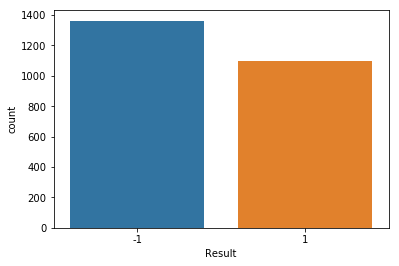

In [36]:
#data1.columns=list(data1.columns[:-1])+['label]
sb.countplot(x='Result',data=data1)
plt.savefig('f:/phsing_website_count.png')
plt.show()

In [27]:
train, test = tr_te_split(data1, t_size=0.2)

In [13]:
np.sign(-90)

-1